In [1]:
########## import some useful package ##########

import time
t1 = time.time()

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import ripser
import persim

In [2]:
########## read the data ##########

processes = ["hhvv", "hhmumu", "jjBG_ptcut", "ttBG_ptcut", "bbBG_ptcut", "wwBG", "wwvvBG", "zzvvBG"]
event_type = [str(i)+"_500K" for i in processes]

Xsection = [4.0360050e-02, +3.3945676e-03, 1.345150e+01, 4.423600e+00, 2.325600e+00, 1.506969e+02, 1.224052e+01, 6.473005e+00]     ### unit: fb
Luminosity = 1000   ### unit: fb^-1
simulation_num = 500000

features = ["VLCjetR10N2", "VLCjetR10N2.PT", "VLCjetR10N2.Eta", "VLCjetR10N2.Phi", "VLCjetR10N2.Mass", "MissingET.MET", "VLCjetR10N2.BTag"]

##### set data path #####

event_path = []
for type in event_type:
    event_path.append("/data/Chen-Wang/mucollider/" + type + "/delphes_output.root")

##### get the data file #####

data_file =[]
for path in event_path:
    data_file.append(uproot.open(path))
    
##### read data with features #####
events = []     ### total events
for process in processes:
    tmp_events = []
    for feature in features:
        tmp_events.append(data_file[processes.index(process)]["Delphes;1"][feature].array())
    tmp_events = np.expand_dims(tmp_events, axis=-1)
    tmp_events = tmp_events.transpose((1,0,2))
    tmp_events = np.squeeze(tmp_events,axis=(2,))
    events.append(tmp_events)
del tmp_events

In [3]:
########## define useful function ##########

##### calculate significance #####

def significance(s,b):
    return np.sqrt(2*((s+b)*np.log(1+s/b)-s))

##### count event number #####

def count(events):
    events_num = []
    for i, process in enumerate(processes):
        events_num.append(len(events[processes.index(process)]))
        print("There are", events_num[i], process, "events. Corresponding cross section:", Xsection[processes.index(process)]*events_num[i]/simulation_num, "(fb)")
        
##### select if Fat Jet >= 2 #####
        
def Fat_Jet_selection(events):
    where1 = np.where(events[:,features.index("VLCjetR10N2")]>=2)
    return events[where1]

##### select if M_jet_leading > XX GeV #####

def mass_leading_selection(events, low_mass_cut, high_mass_cut):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][features.index("VLCjetR10N2.Mass")][0]<low_mass_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.Mass")][0]>high_mass_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if M_jet_subleading > XX GeV #####

def mass_subleading_selection(events, low_mass_cut, high_mass_cut):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][features.index("VLCjetR10N2.Mass")][1]<low_mass_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.Mass")][1]>high_mass_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_leading > XX GeV #####

def pT_leading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][0]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][0]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if pT_J_subleading > XX GeV #####

def pT_subleading_selection(events, low_pT_cut, high_pT_cut):
    where1 = []
    for i in range(len(events)):
        switch = 1
        if events[i][features.index("VLCjetR10N2.PT")][1]<low_pT_cut:
            switch=0
        if events[i][features.index("VLCjetR10N2.PT")][1]>high_pT_cut:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### define X_HH (defined in 2207.09602v2) #####

def calculate_X_HH(event):
    jet_mass1 = event[features.index("VLCjetR10N2.Mass")][0]
    jet_mass2 = event[features.index("VLCjetR10N2.Mass")][1]
    diff1 = np.abs(jet_mass1 - 124)
    diff2 = np.abs(jet_mass2 - 124)
    if diff1<diff2:
        m1 = jet_mass1
        m2 = jet_mass2
    else:
        m1 = jet_mass2
        m2 = jet_mass1
    return np.sqrt(((m1-124)/(0.1*m1+0.00001))**2 + ((m2-115)/(0.1*m2+0.00001))**2)

##### calculate M_JJ #####

def calculate_M_JJ(event):
    p = [0,0,0,0]    ### four momentum
    for i in range(2):    ### leading jet and sub-leading jet
        pt = event[features.index("VLCjetR10N2.PT")][i]
        eta = event[features.index("VLCjetR10N2.Eta")][i]
        phi = event[features.index("VLCjetR10N2.Phi")][i]
        mass = event[features.index("VLCjetR10N2.Mass")][i]
        p[1] = p[1] + pt*np.cos(phi)    ### px
        p[2] = p[2] + pt*np.sin(phi)    ### py
        p[3] = p[3] + pt*np.sinh(eta)    ### pz
        p[0] = p[0] + np.sqrt( mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
    M_JJ = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
    return M_JJ

##### calculate pT_JJ #####

def calculate_pT_JJ(event):
    p = [0,0,0,0]    ### four momentum
    for i in range(2):    ### leading jet and sub-leading jet
        pt = event[features.index("VLCjetR10N2.PT")][i]
        eta = event[features.index("VLCjetR10N2.Eta")][i]
        phi = event[features.index("VLCjetR10N2.Phi")][i]
        mass = event[features.index("VLCjetR10N2.Mass")][i]
        p[1] = p[1] + pt*np.cos(phi)    ### px
        p[2] = p[2] + pt*np.sin(phi)    ### py
        p[3] = p[3] + pt*np.sinh(eta)    ### pz
        p[0] = p[0] + np.sqrt( mass**2 + (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )    ### energy
    pT_JJ = np.sqrt(p[1]**2 + p[2]**2)
    return pT_JJ

##### calculate \Delta_\Eta #####

def calculate_dEta_JJ(event):
    return np.abs(event[features.index("VLCjetR10N2.Eta")][0] - event[features.index("VLCjetR10N2.Eta")][1])

In [4]:
########## preselection ##########

print("Before any selection:")
count(events)

##### 2 fat jet selection #####

for process in processes:
    events[processes.index(process)] = Fat_Jet_selection(events[processes.index(process)])
print("\nAfter 2 fat jet selection:")
count(events)

Before any selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 hhmumu events. Corresponding cross section: 0.0033945676 (fb)
There are 500000 jjBG_ptcut events. Corresponding cross section: 13.4515 (fb)
There are 500000 ttBG_ptcut events. Corresponding cross section: 4.4236 (fb)
There are 500000 bbBG_ptcut events. Corresponding cross section: 2.3256 (fb)
There are 500000 wwBG events. Corresponding cross section: 150.6969 (fb)
There are 500000 wwvvBG events. Corresponding cross section: 12.24052 (fb)
There are 500000 zzvvBG events. Corresponding cross section: 6.473005 (fb)

After 2 fat jet selection:
There are 500000 hhvv events. Corresponding cross section: 0.04036005 (fb)
There are 500000 hhmumu events. Corresponding cross section: 0.0033945676 (fb)
There are 499999 jjBG_ptcut events. Corresponding cross section: 13.451473097 (fb)
There are 500000 ttBG_ptcut events. Corresponding cross section: 4.4236 (fb)
There are 500000 bbBG_ptcut

In [5]:
########## visualization of kinematics ##########

m_J_leading = []
m_J_subleading = []
pt_J_leading = []
pt_J_subleading = []

##### calculate kinematics #####

for process in processes:
    tmp_m1 = []
    tmp_m2 = []
    tmp_pt1 = []
    tmp_pt2 = []
    for i in range(len(events[processes.index(process)])):
        tmp_m1.append(events[processes.index(process)][i][features.index("VLCjetR10N2.Mass")][0])
        tmp_m2.append(events[processes.index(process)][i][features.index("VLCjetR10N2.Mass")][1])
        tmp_pt1.append(events[processes.index(process)][i][features.index("VLCjetR10N2.PT")][0])
        tmp_pt2.append(events[processes.index(process)][i][features.index("VLCjetR10N2.PT")][1])
    m_J_leading.append(tmp_m1)
    m_J_subleading.append(tmp_m2)
    pt_J_leading.append(tmp_pt1)
    pt_J_subleading.append(tmp_pt2)
    print("Time:{:^8.4f}(s)".format(time.time()-t1))
del tmp_m1, tmp_m2, tmp_pt1, tmp_pt2

Time:30.7456 (s)
Time:31.8060 (s)
Time:32.8931 (s)
Time:34.0117 (s)
Time:35.1577 (s)
Time:36.2171 (s)
Time:37.3080 (s)
Time:38.4128 (s)


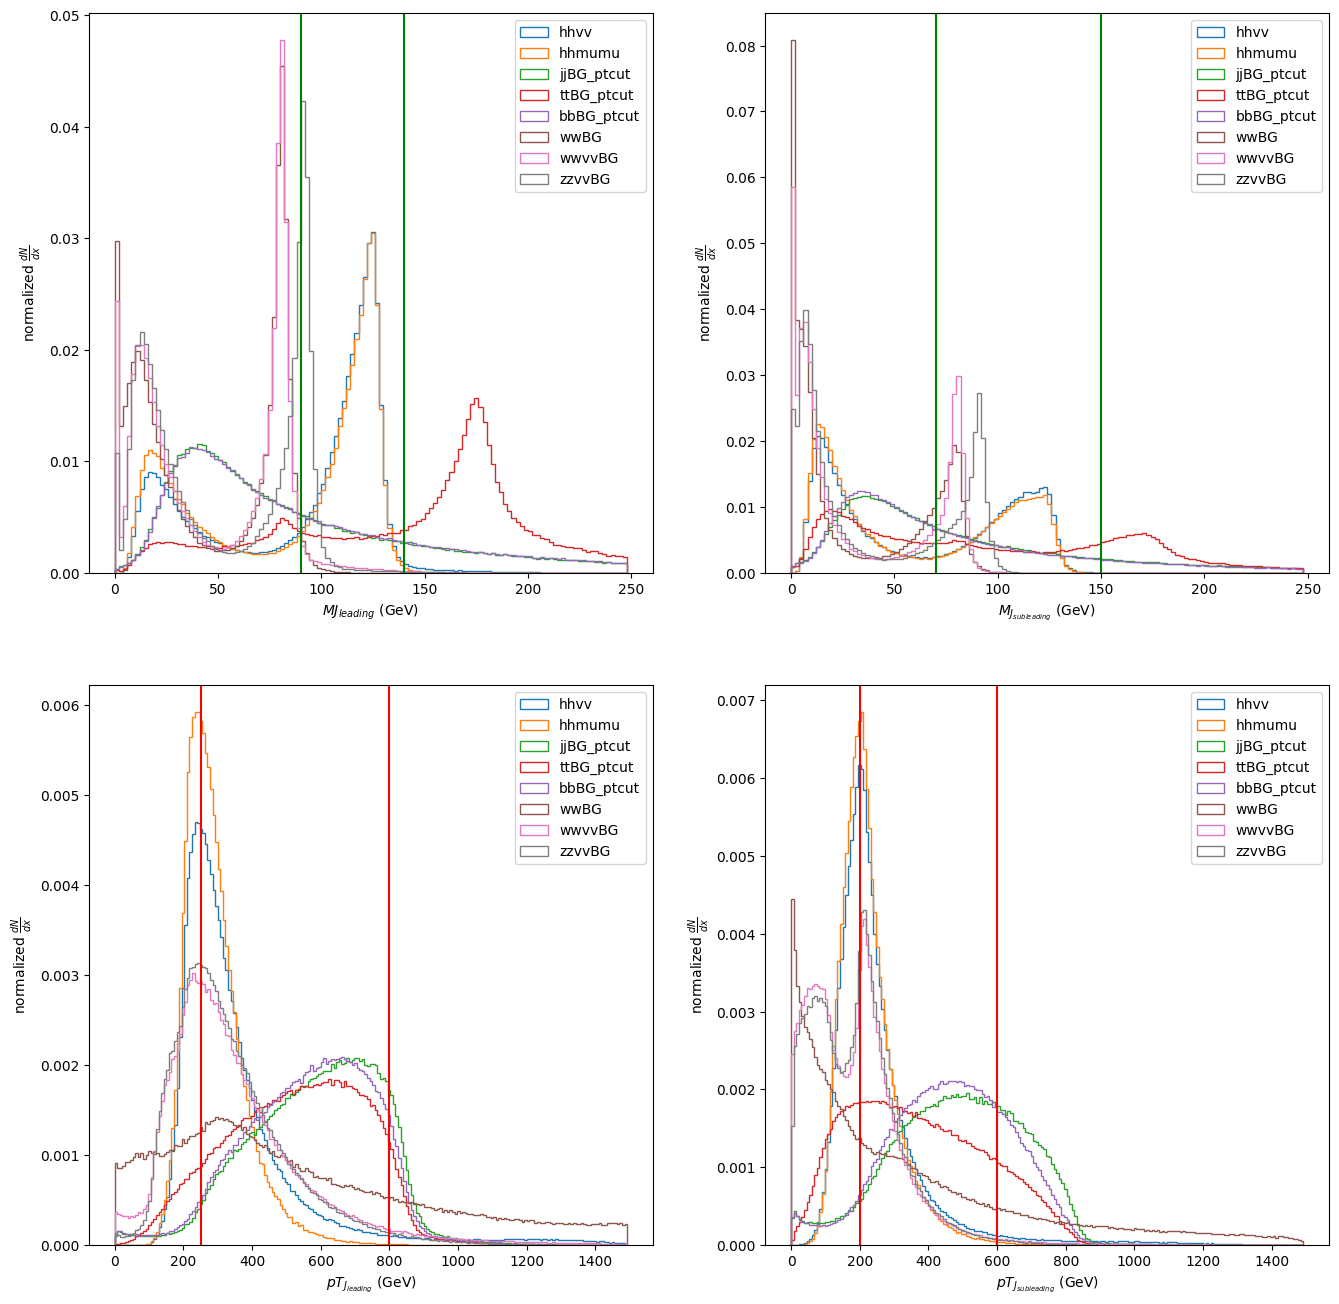

In [6]:
##### plot the histogram #####

fig = plt.figure(figsize=(16, 16))

fig.add_subplot(221)     ### plot leading jet mass
bins = np.arange(0,250,2)
for process in processes:
    plt.hist(m_J_leading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(90, color='g')
plt.axvline(140, color='g')
plt.xlabel(r"$M{J_{leading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(222)     ### plot subleading jet mass
bins = np.arange(0,250,2)
for process in processes:
    plt.hist(m_J_subleading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(70, color='g')
plt.axvline(150, color='g')
plt.xlabel(r"$M_{J_{subleading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(223)     ### plot leading jet PT
bins = np.arange(0,1500,7.5)
for process in processes:
    plt.hist(pt_J_leading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(250, color='r')
plt.axvline(800, color='r')
plt.xlabel(r"$pT_{J_{leading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(224)     ### plot subleading jet PT
bins = np.arange(0,1500,7.5)
for process in processes:
    plt.hist(pt_J_subleading[processes.index(process)], bins=bins, label=process, histtype='step', density=True)
plt.axvline(200, color='r')
plt.axvline(600, color='r')
plt.xlabel(r"$pT_{J_{subleading}} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

plt.show()

In [7]:
########## Do some basic cuts ##########

##### leading jet pT selection #####

leading_low_pT_cut = 250   ### GeV
leading_high_pT_cut = 800   ### GeV
for process in processes:
    events[processes.index(process)] = pT_leading_selection(events[processes.index(process)], leading_low_pT_cut, leading_high_pT_cut)
print("\nAfter leading jet pT selection:")
count(events)

##### subleading jet pT selection #####

subleading_low_pT_cut = 200   ### GeV
subleading_high_pT_cut = 600   ### GeV
for process in processes:
    events[processes.index(process)] = pT_subleading_selection(events[processes.index(process)], subleading_low_pT_cut, subleading_high_pT_cut)
print("\nAfter subleading jet pT selection:")
count(events)

##### leading jet mass selection #####

leading_low_mass_cut = 90
leading_high_mass_cut = 140
for process in processes:
    events[processes.index(process)] = mass_leading_selection(events[processes.index(process)], leading_low_mass_cut, leading_high_mass_cut)
print("\nAfter leading jet mass selection:")
count(events)

##### subleading jet mass selection #####

subleading_low_mass_cut = 70
subleading_high_mass_cut = 150
for process in processes:
    events[processes.index(process)] = mass_subleading_selection(events[processes.index(process)], subleading_low_mass_cut, subleading_high_mass_cut)
print("\nAfter subleading jet mass selection:")
count(events)


After leading jet pT selection:
There are 331849 hhvv events. Corresponding cross section: 0.0267868844649 (fb)
There are 312319 hhmumu events. Corresponding cross section: 0.0021203759165288 (fb)
There are 424750 jjBG_ptcut events. Corresponding cross section: 11.42704925 (fb)
There are 421050 ttBG_ptcut events. Corresponding cross section: 3.7251135600000005 (fb)
There are 435539 bbBG_ptcut events. Corresponding cross section: 2.0257789968 (fb)
There are 239543 wwBG events. Corresponding cross section: 72.1967750334 (fb)
There are 287068 wwvvBG events. Corresponding cross section: 7.027723190720001 (fb)
There are 295360 zzvvBG events. Corresponding cross section: 3.8237335135999997 (fb)

After subleading jet pT selection:
There are 245220 hhvv events. Corresponding cross section: 0.019794182922 (fb)
There are 236348 hhmumu events. Corresponding cross section: 0.0016045985262496 (fb)
There are 302184 jjBG_ptcut events. Corresponding cross section: 8.129656151999999 (fb)
There are 294

In [8]:
########## visualization of other kinematics ##########

missET = []
X_HH = []
M_JJ = []
pT_JJ = []
dEta_JJ = []
BTag_leading = []
BTag_subleading = []

##### calculate kinematics #####

for process in processes:
    tmp_met = []
    tmp_X_HH = []
    tmp_M_JJ = []
    tmp_pT_JJ = []
    tmp_dEta_JJ = []
    tmp_Btag_0 = []
    tmp_Btag_1 = []
    for i in range(len(events[processes.index(process)])):
        tmp_met.append(events[processes.index(process)][i][features.index("MissingET.MET")][0])
        tmp_X_HH.append(calculate_X_HH(events[processes.index(process)][i]))
        tmp_M_JJ.append(calculate_M_JJ(events[processes.index(process)][i]))
        tmp_pT_JJ.append(calculate_pT_JJ(events[processes.index(process)][i]))
        tmp_dEta_JJ.append(calculate_dEta_JJ(events[processes.index(process)][i]))
        tmp_Btag_0.append(events[processes.index(process)][i][features.index("VLCjetR10N2.BTag")][0])
        tmp_Btag_1.append(events[processes.index(process)][i][features.index("VLCjetR10N2.BTag")][1])
    missET.append(tmp_met)
    X_HH.append(tmp_X_HH)
    M_JJ.append(tmp_M_JJ)
    pT_JJ.append(tmp_pT_JJ)
    dEta_JJ.append(tmp_dEta_JJ)
    BTag_leading.append(tmp_Btag_0)
    BTag_subleading.append(tmp_Btag_1)
    print("Time:{:^8.4f}(s)".format(time.time()-t1))
    
del tmp_met, tmp_X_HH, tmp_M_JJ, tmp_pT_JJ, tmp_dEta_JJ, tmp_Btag_0, tmp_Btag_1

Time:148.5004(s)
Time:161.3669(s)
Time:163.0906(s)
Time:165.0933(s)
Time:167.0035(s)
Time:167.0838(s)
Time:167.3380(s)
Time:173.4106(s)


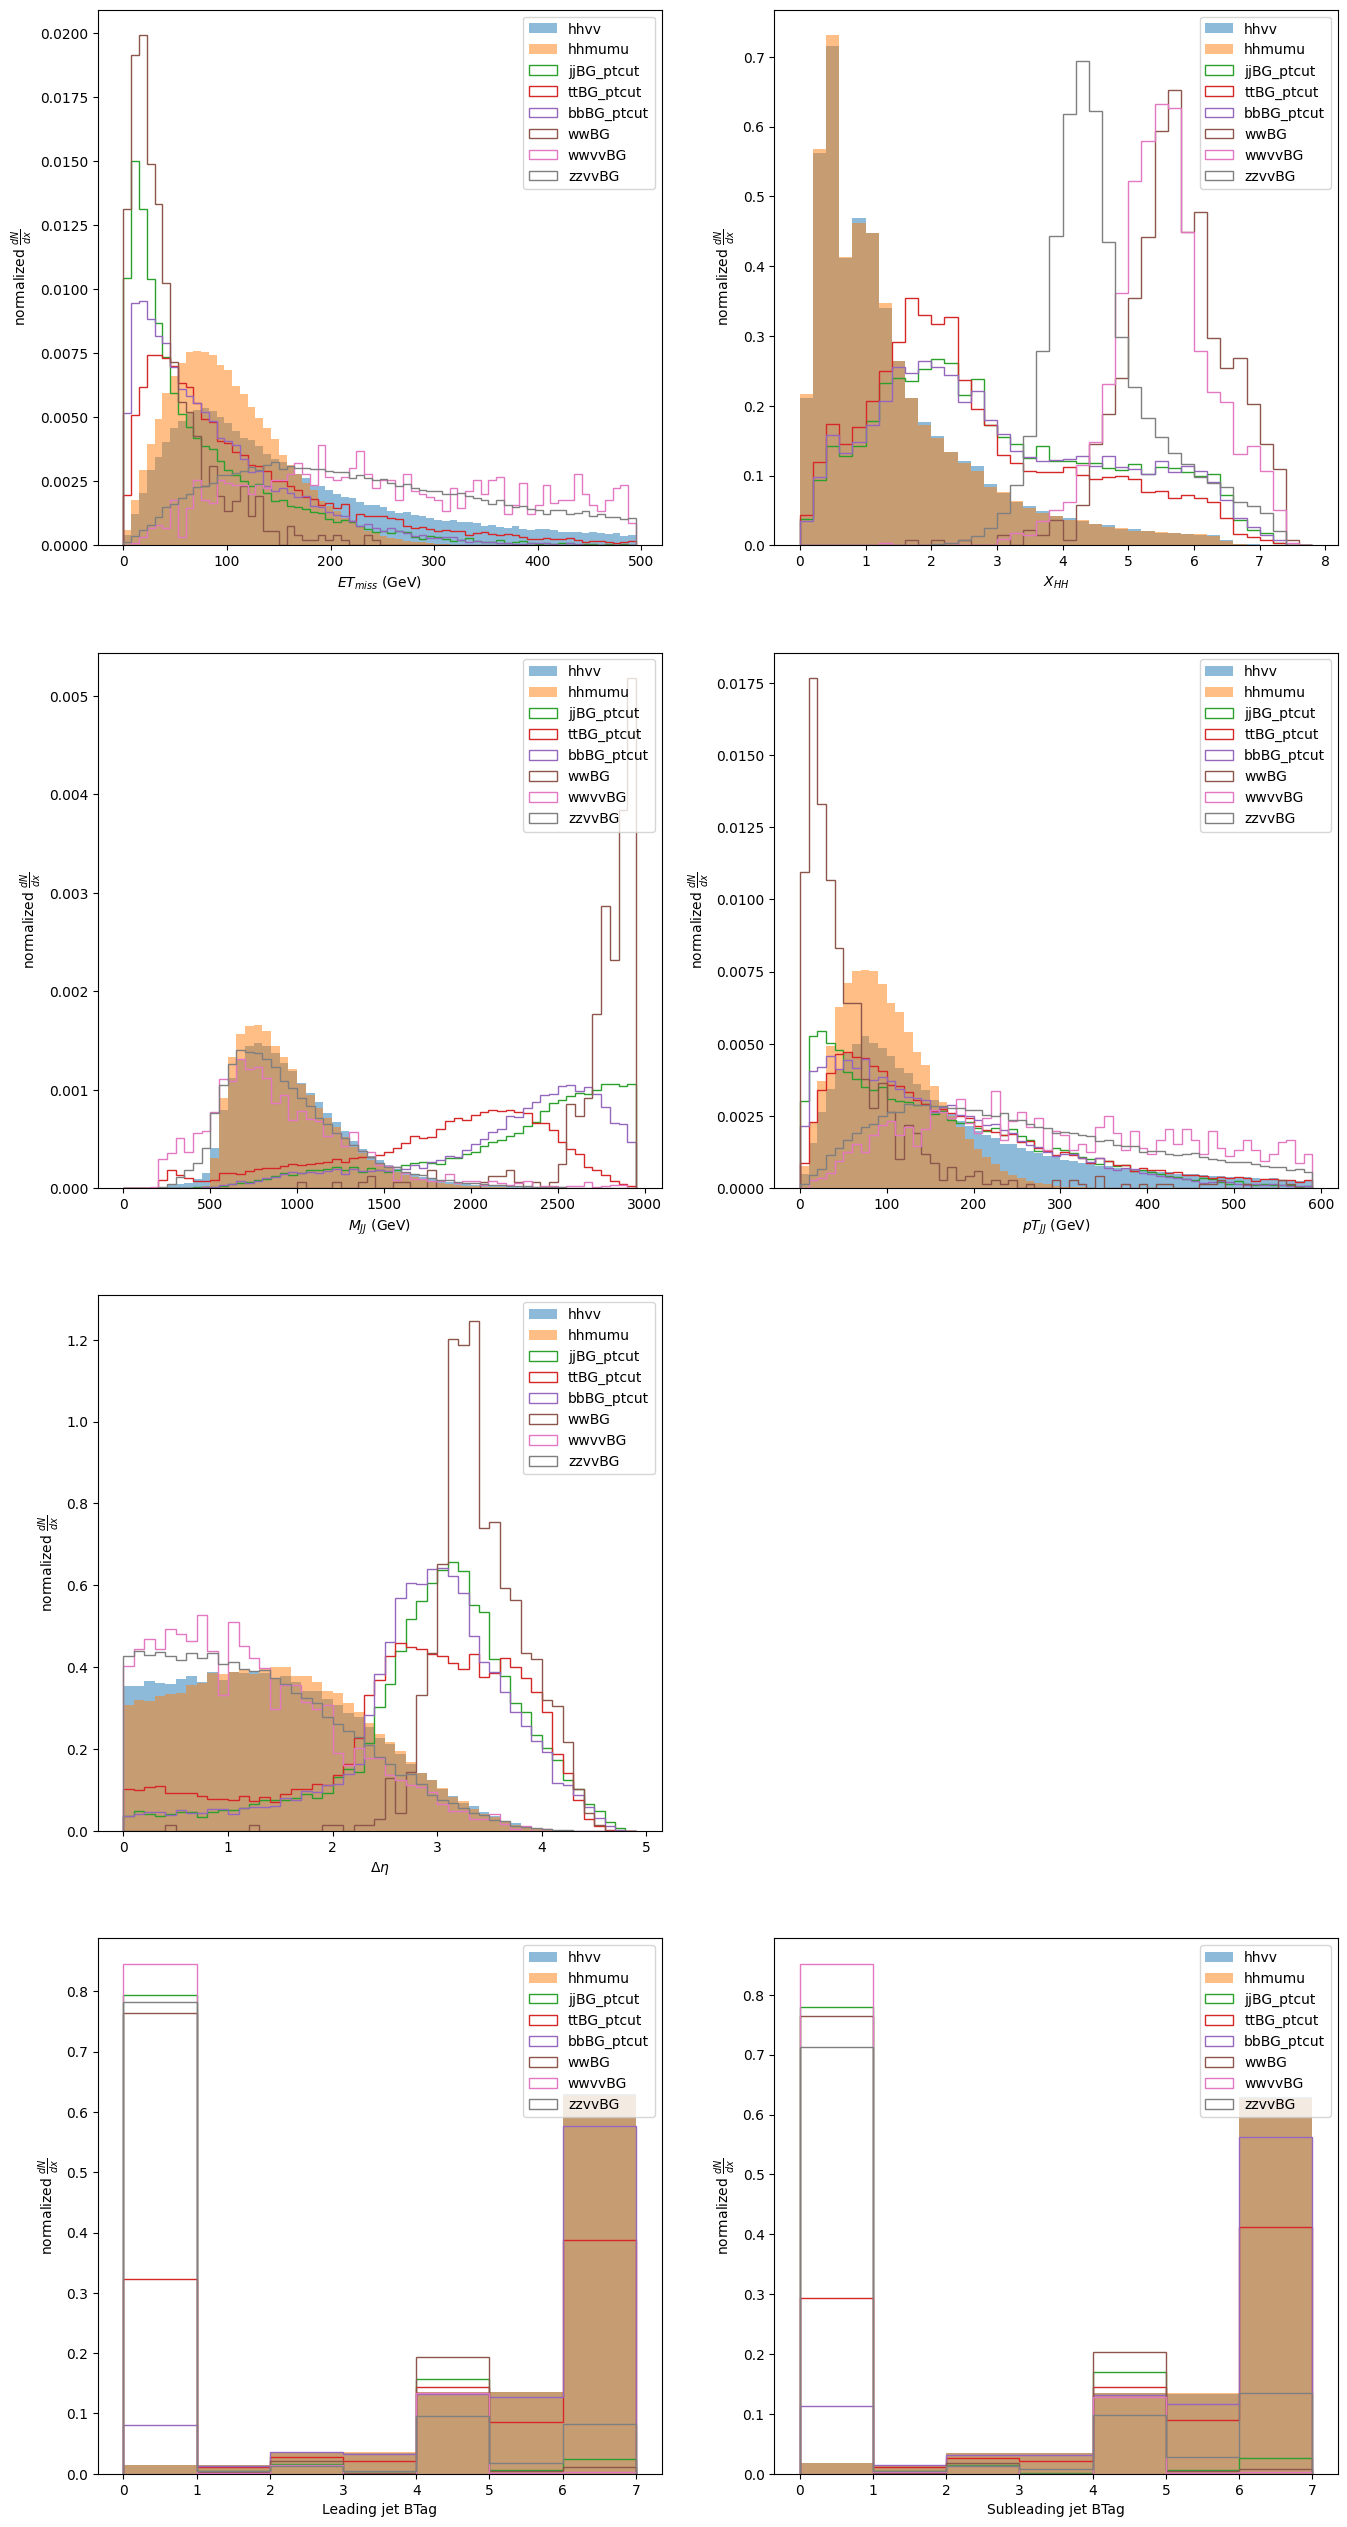

In [9]:
##### plot the histogram #####

fig = plt.figure(figsize=(16, 32))

fig.add_subplot(421)     ### plot MET
bins = np.arange(0,500,7.5)
for process in processes:
    plt.hist(missET[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"$ET_{miss} ~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(422)     ### plot X_HH
bins = np.arange(0,8,0.2)
for process in processes:
    plt.hist(X_HH[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"$X_{HH}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(423)     ### plot M_JJ
bins = np.arange(0,3000,50)
for process in processes:
    plt.hist(M_JJ[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"$M_{JJ}~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(424)     ### plot pT_JJ
bins = np.arange(0,600,10)
for process in processes:
    plt.hist(pT_JJ[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"$pT_{JJ}~\rm{(GeV)}$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(425)     ### plot dEta_JJ
bins = np.arange(0,5,0.1)
for process in processes:
    plt.hist(dEta_JJ[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"$\Delta \eta$", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(427)     ### plot BTag of leading jet
bins = np.arange(0,8,1)
for process in processes:
    plt.hist(BTag_leading[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"Leading jet BTag", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

fig.add_subplot(428)     ### plot BTag of subleading jet
bins = np.arange(0,8,1)
for process in processes:
    plt.hist(BTag_subleading[processes.index(process)], bins=bins, label=process, histtype=('stepfilled' if (process=='hhvv' or process=='hhmumu') else 'step'), density=True, alpha=(0.5 if (process=='hhvv' or process=='hhmumu') else 1))
plt.xlabel(r"Subleading jet BTag", fontsize=10)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=10)
plt.legend()

plt.show()

In [10]:
# data_file[processes=="hhvv"]["Delphes;1"].show()

##### show the event #####

events[0][4]

array([2, array([291.61404, 276.74756], dtype=float32),
       array([-0.14162795, -0.41107407], dtype=float32),
       array([-0.98961824,  1.8678468 ], dtype=float32),
       array([128.48024,  99.43183], dtype=float32),
       array([85.94896], dtype=float32), array([7, 6], dtype=uint32)],
      dtype=object)

In [11]:
s = 10.2184381 + 0.822198
b = 1654.8229906
significance(s,b)

0.27110434159397123

In [12]:
print("Time:{:^8.4f}(s)".format(time.time()-t1))

Time:182.9257(s)
